In [1]:
import networkx as nx
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.constants import DatasetPath
from datasets.schema import DatasetSchema
from datasets.loading import load_igraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetPath('DBLP-V1')
schema = DatasetSchema.load_schema(DATASET.name)
G = load_igraph(schema, prefix_id=True)

In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: True
Has edge timestamp: False


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

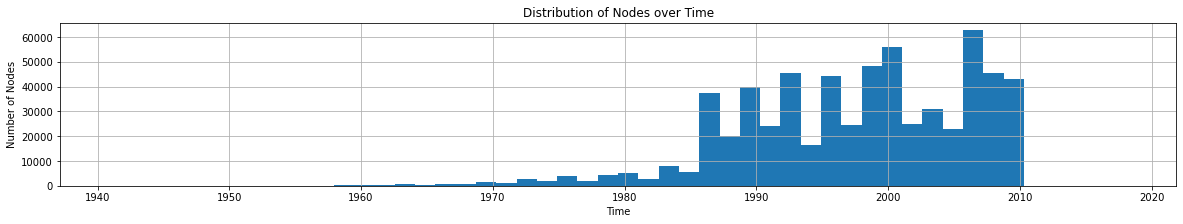

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

No edge timestamp data available


# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 1238188
Number of Edges: 2501669
Density: 3.2635255111747637e-06


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 4.040854862104947
Median Degree: 2.0


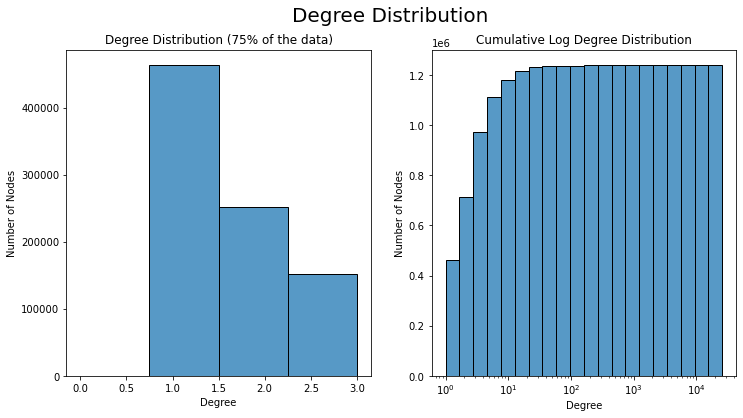

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,25929,
1,7107,Communications of the ACM
2,5057,Computer
3,3715,Jr.
4,3451,IEEE Transactions on Computers
5,3388,Discrete Mathematics
6,3271,Theoretical Computer Science
7,3091,Journal of Computational and Applied Mathematics
8,2903,Microelectronic Engineering
9,2897,Journal of Computational Physics


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [15]:
# Use the largest connected component
G_cc = G.clusters().giant()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [16]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.021
Diameter: 35


In [18]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    u = 0
    # metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

,degree_centrality,betweenness_centrality,page_rank,transitivity
count,1.157439e+06,1.157439e+06,1.157439e+06,764630.000000
mean,3.661680e-06,6.230402e-06,8.639764e-07,0.030868
std,2.625553e-05,1.385291e-03,1.037383e-05,0.105881
min,8.639772e-07,0.000000e+00,1.296248e-07,0.000000
25%,8.639772e-07,0.000000e+00,2.764725e-07,0.000000
50%,1.727954e-06,0.000000e+00,4.967864e-07,0.000000
75%,3.455909e-06,8.639787e-07,9.560036e-07,0.000000
max,2.240206e-02,1.000001e+00,1.032736e-02,1.000000


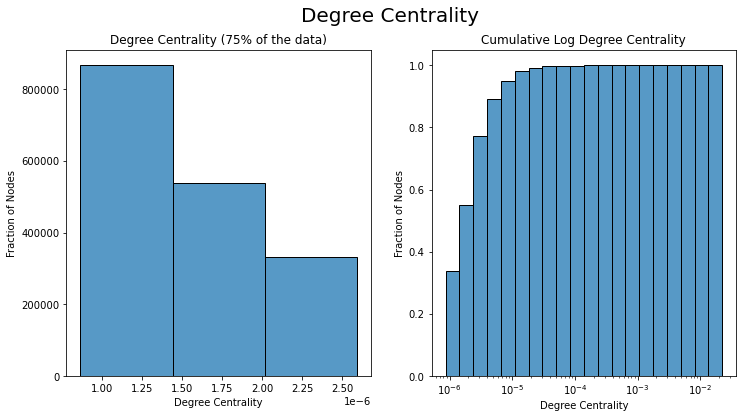

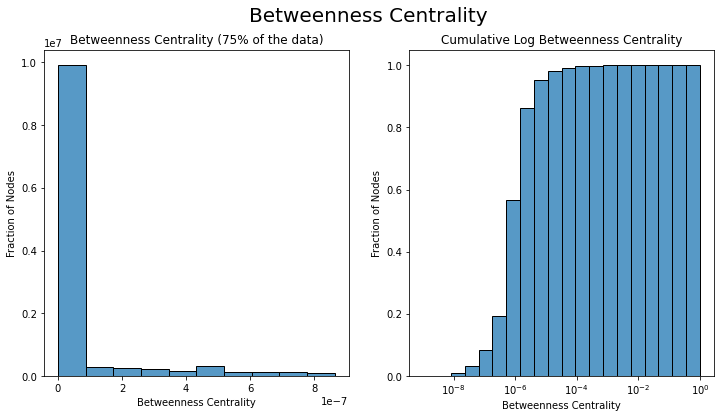

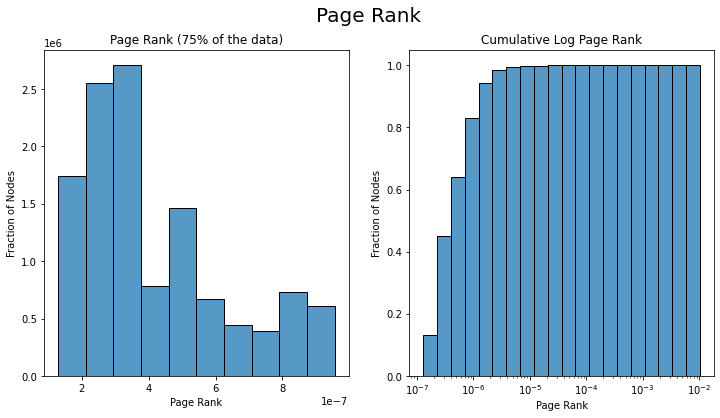

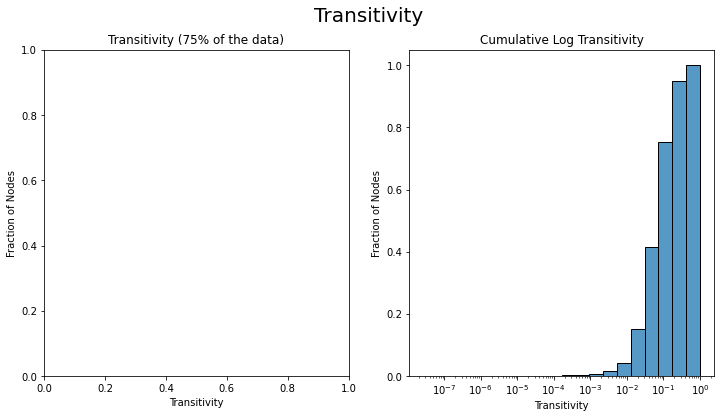

In [19]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [20]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.022402,,1.000001,Normal forms and Fatou-Bieberbach domains,0.010327,,1.0,Andreas Seidl
1,0.006140,Communications of the ACM,1.000000,Proceedings of the 5th WSEAS International Con...,0.001390,Computer,1.0,Eddie S. Washington
2,0.004369,Computer,0.237020,An analysis of average search cost of the exte...,0.001386,Communications of the ACM,1.0,Alexander Viehl
3,0.003210,Jr.,0.236308,"The art of computer programming, volume 1 (3rd...",0.000894,Discrete Mathematics,1.0,Sanja Fidler
4,0.002982,IEEE Transactions on Computers,0.167751,Autonomous agent learning by a creativity opti...,0.000718,Journal of Computational and Applied Mathematics,1.0,Chau-Young Ivan Lin
5,0.002927,Discrete Mathematics,0.109469,Towards the formalization of knowledge represe...,0.000673,Jr.,1.0,P. B. Bailey
6,0.002826,Theoretical Computer Science,0.102337,Foundations of logic programming; (2nd extende...,0.000664,BYTE,1.0,Sheng Yang
7,0.002671,Journal of Computational and Applied Mathematics,0.096488,Electronic meeting systems,0.000660,Theoretical Computer Science,1.0,Han E. H. Meijer
8,0.002508,Microelectronic Engineering,0.095325,Watermarking oriented video modelling in the w...,0.000637,Fuzzy Sets and Systems,1.0,Jan Hannemann
9,0.002503,Journal of Computational Physics,0.089959,Application and numerical investigation of wav...,0.000597,Information Processing Letters,1.0,Martien A. Hulsen


## Connected Components Statistics

In [21]:
print(f'Number of Connected Components: {len(G.components())}')
largest_cc = G.components().giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 32767
Size of the largest component: 1157439


Text(0.5, 1.0, 'Connected Components')

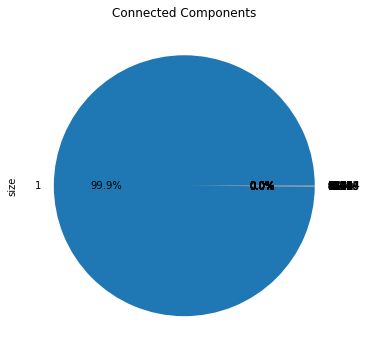

In [38]:
df_tmp = pd.Series(list(map(len, G.components())), name='size', index=range(1,len(G.components())+1))
ax = df_tmp.sort_values(ascending=False).head(30).plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [23]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 3


,type,count,degree_avg,degree_median
Author,Author,595775,2.245311,1.0
Venue,Venue,12609,42.130066,14.0
Paper,Paper,629804,4.976818,3.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

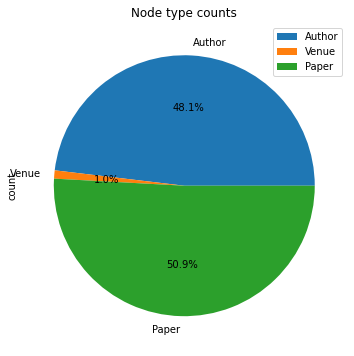

In [24]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

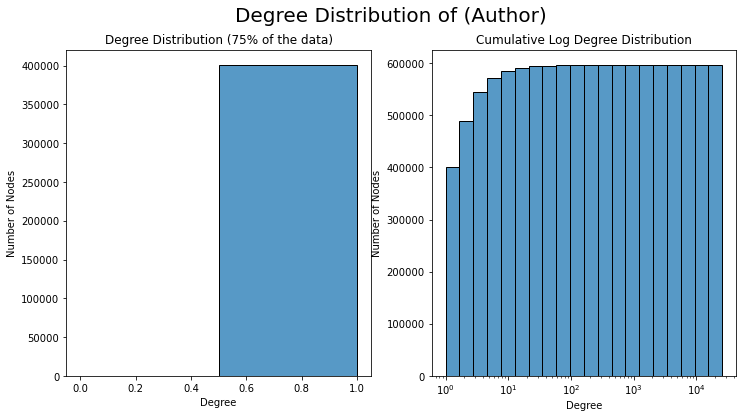

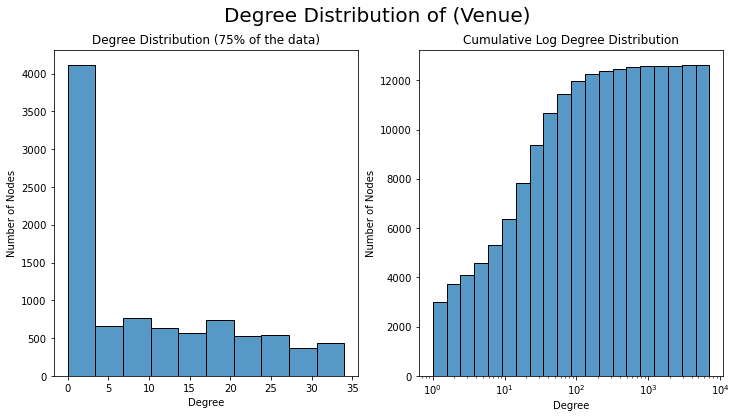

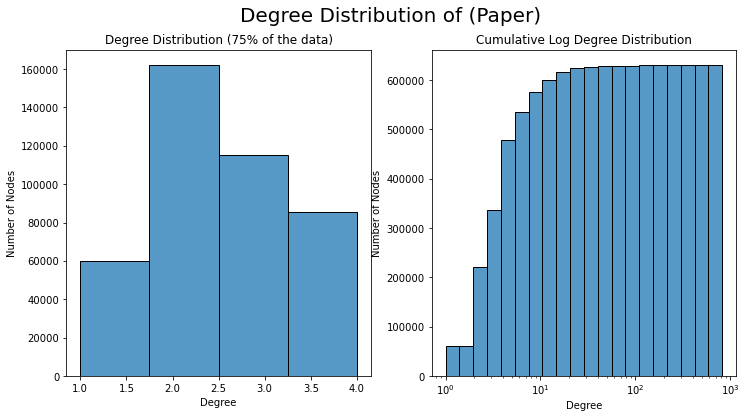

In [25]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [26]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (Author)


,value,label
0,25929,
1,3715,Jr.
2,695,III
3,392,II
4,390,Staff
5,209,Ben Shneiderman
6,206,Philip S. Yu
7,176,Elisa Bertino
8,171,Thomas J. Cashman
9,170,Ming Li


Top 10 Degree Nodes of Type (Venue)


,value,label
0,7107,Communications of the ACM
1,5057,Computer
2,3451,IEEE Transactions on Computers
3,3388,Discrete Mathematics
4,3271,Theoretical Computer Science
5,3091,Journal of Computational and Applied Mathematics
6,2903,Microelectronic Engineering
7,2897,Journal of Computational Physics
8,2794,Fuzzy Sets and Systems
9,2690,Information Processing Letters


Top 10 Degree Nodes of Type (Paper)


,value,label
0,819,Introduction to algorithms
1,794,"Compilers: principles, techniques, and tools"
2,649,C4.5: programs for machine learning
3,590,Smalltalk-80: the language and its implementation
4,570,A relational model of data for large shared da...
5,562,"Time, clocks, and the ordering of events in a ..."
6,554,The nature of statistical learning theory
7,527,Pattern Classification (2nd Edition)
8,523,"The art of computer programming, volume 1 (3rd..."
9,505,"The art of computer programming, volume 2 (3rd..."


### Edge Type Statistics

In [27]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 3


,type,count
AUTHORED,AUTHORED,1337700
PUBLISHED_IN,PUBLISHED_IN,531218
CITED,CITED,632751


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

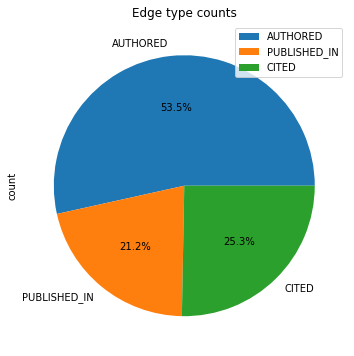

In [28]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [29]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [30]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for Author


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.022402,,0.064172,,0.010327,,1.0,Rocco Trombetti
1,0.003210,Jr.,0.039705,Jr.,0.000673,Jr.,1.0,F. C. Langbein
2,0.000600,III,0.013802,Yiming Li,0.000142,Staff,1.0,Colin Mcdiarmid
3,0.000339,II,0.010502,Lixin Gao,0.000121,III,1.0,Xingguo Xiong
4,0.000337,Staff,0.008788,Tao Li,0.000083,Stephen L. Nelson,1.0,Garry Robins
5,0.000181,Ben Shneiderman,0.007798,Luonan Chen,0.000080,Que Corporation,1.0,Jana Z. Sedivy
6,0.000178,Philip S. Yu,0.005654,Hiroshi Maeda,0.000073,Microsoft Corporation,1.0,Sophie Garidel
7,0.000152,Elisa Bertino,0.005643,Herwig Bruneel,0.000069,II,1.0,Carlos Magno C. Jacinto
8,0.000148,Thomas J. Cashman,0.004104,Xiao Liu,0.000062,Gilbert Held,1.0,B. Prasada
9,0.000147,Ming Li,0.002911,S. A. Belbas,0.000060,Ruth Maran,1.0,Lifu Zhang


Top 10 Nodes by Statistic for Venue


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.006140,Communications of the ACM,1.000000,Proceedings of the 5th WSEAS International Con...,0.001390,Computer,1.000000,Proceedings of the 1977 symposium on Artificia...
1,0.004369,Computer,0.044159,Communications of the ACM,0.001386,Communications of the ACM,0.666667,Proceedings of the 1993 ACM/ONR workshop on Pa...
2,0.002982,IEEE Transactions on Computers,0.015399,IEEE Transactions on Pattern Analysis and Mach...,0.000894,Discrete Mathematics,0.333333,Proceedings of the sixteenth ACM SIGACT-SIGMOD...
3,0.002927,Discrete Mathematics,0.011494,Journal of Computational and Applied Mathematics,0.000718,Journal of Computational and Applied Mathematics,0.277778,Proceeding of the 2007 conference on Advances ...
4,0.002826,Theoretical Computer Science,0.011289,Microelectronic Engineering,0.000664,BYTE,0.196970,Proceedings of the Workshop on Frontiers in Co...
5,0.002671,Journal of Computational and Applied Mathematics,0.011179,Signal Processing,0.000660,Theoretical Computer Science,0.181538,2007 Future of Software Engineering
6,0.002508,Microelectronic Engineering,0.010695,Discrete Applied Mathematics,0.000637,Fuzzy Sets and Systems,0.153846,Proceeding of the 2008 conference on Applicati...
7,0.002503,Journal of Computational Physics,0.010172,Fuzzy Sets and Systems,0.000597,Information Processing Letters,0.128205,Decision Analysis
8,0.002414,Fuzzy Sets and Systems,0.008573,IEEE Transactions on Computers,0.000588,IEEE Transactions on Computers,0.107143,Proceedings of the Workshop on Parsing German
9,0.002324,Information Processing Letters,0.008368,Artificial Intelligence,0.000572,Journal of Computational Physics,0.106061,Proceedings of the 2nd International Workshop ...


Top 10 Nodes by Statistic for Paper


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000708,Introduction to algorithms,1.000001,Normal forms and Fatou-Bieberbach domains,0.000084,An overview of the BlueGene/L Supercomputer,1.0,The design and performance of a hierarchical m...
1,0.000686,"Compilers: principles, techniques, and tools",0.237020,An analysis of average search cost of the exte...,0.000057,Introduction to algorithms,1.0,A Parallel Randomized Approximation Scheme for...
2,0.000561,C4.5: programs for machine learning,0.236308,"The art of computer programming, volume 1 (3rd...",0.000047,The nature of statistical learning theory,1.0,On the composition and decomposition of datalo...
3,0.000510,Smalltalk-80: the language and its implementation,0.167751,Autonomous agent learning by a creativity opti...,0.000045,"Compilers: principles, techniques, and tools",1.0,Efficient algorithms for distributed simulatio...
4,0.000492,A relational model of data for large shared da...,0.109469,Towards the formalization of knowledge represe...,0.000044,C4.5: programs for machine learning,1.0,Metrics for object-oriented software design
5,0.000486,"Time, clocks, and the ordering of events in a ...",0.102337,Foundations of logic programming; (2nd extende...,0.000043,"The art of computer programming, volume 2 (3rd...",1.0,Signature and specification matching
6,0.000479,The nature of statistical learning theory,0.096488,Electronic meeting systems,0.000043,Recent AI-Related Dissertations,1.0,Non-monotonicity and change
7,0.000455,Pattern Classification (2nd Edition),0.095325,Watermarking oriented video modelling in the w...,0.000042,"Simulation Modeling and Analysis, 2nd edition",1.0,"Using Wireless Communications in Business, 1st..."
8,0.000452,"The art of computer programming, volume 1 (3rd...",0.089959,Application and numerical investigation of wav...,0.000042,"The art of computer programming, volume 1 (3rd...",1.0,Anatomy-based surface generation for articulat...
9,0.000436,"The art of computer programming, volume 2 (3rd...",0.065684,A Theory for Multiresolution Signal Decomposit...,0.000039,Adaptation in natural and artificial systems,1.0,An extension of a first-order language and its...


# Clustering

## No Clustering Modularity

In [31]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 1.1102230246251565e-16


### Louvain

In [32]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.7804416514157961
Number of communities: 269


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

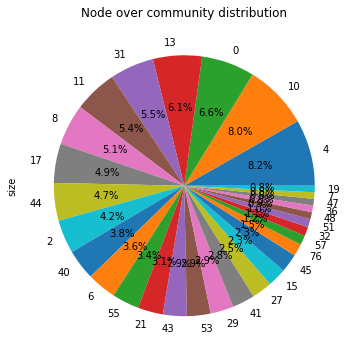

In [33]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000702,Computer Networks and ISDN Systems,0.010502,Lixin Gao,0.000200,Computer Networks and ISDN Systems,1.0,Prashant G. Mehta
1,0.000651,ACM SIGOPS Operating Systems Review,0.009728,Multi-server queues subject to server interrup...,0.000111,Computer Communications,1.0,Mark Aiken
2,0.000639,IEEE/ACM Transactions on Networking (TON),0.005643,Herwig Bruneel,0.000108,Performance Evaluation,1.0,Ronnie Chaiken
3,0.000637,ACM Computing Surveys (CSUR),0.003961,Discrete-Time Models for Communication Systems...,0.000105,ACM SIGCOMM Computer Communication Review,1.0,Sung Hoon Baek
4,0.000619,ACM SIGCOMM Computer Communication Review,0.002407,Early experience with Mesa,0.000102,ACM SIGOPS Operating Systems Review,1.0,Sugat Jain
5,0.000526,ACM SIGMETRICS Performance Evaluation Review,0.002290,IEEE/ACM Transactions on Networking (TON),0.000090,ACM SIGMETRICS Performance Evaluation Review,1.0,Ralph Zainlinger
6,0.000500,Computer Networks: The International Journal o...,0.002176,DCAS is not a silver bullet for nonblocking al...,0.000084,ACM Computing Surveys (CSUR),1.0,V. Agrawala
7,0.000486,Computer Communications,0.002069,DCAS-based concurrent deques,0.000082,Wireless Personal Communications: An Internati...,1.0,Maciej Piechowiak
8,0.000486,"Time, clocks, and the ordering of events in a ...",0.001873,ACM Computing Surveys (CSUR),0.000080,Computer Networks: The International Journal o...,1.0,Stephan Gruber
9,0.000480,Performance Evaluation,0.001770,Computer Networks and ISDN Systems,0.000075,IEEE Internet Computing,1.0,Simone Silvestri


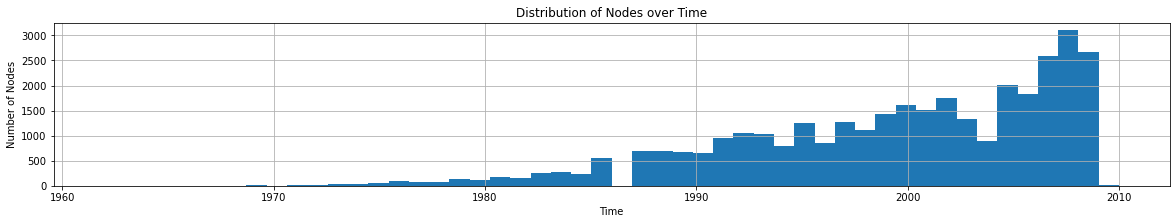

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000278,Ubiquity,0.000429,Ubiquity,0.000105,Ubiquity,0.833333,Software-Implemented Fault Detection Approaches
1,0.000068,Inc.,0.000117,Inc.,0.000025,Inc.,0.666667,Transient software fault tolerance through rec...
2,0.000051,IEEE,0.000088,Inc. Staff,0.000020,IEEE,0.666667,Charles Adetokunbo Shoniregun
3,0.000041,Ubiquity staff,0.000078,IEEE Standard for Information Technology - Por...,0.000019,Institute of Electrical and Electronics Engineers,0.400000,The future of internet security
4,0.000041,Inc. Staff,0.000065,Proceedings of the conference on Intellectual ...,0.000017,Ubiquity staff,0.333333,Software-Based Fault Tolerant Computing
5,0.000033,Proceedings of the conference on Intellectual ...,0.000055,CORPORATE IEEE,0.000016,Inc. Staff,0.333333,Saulius Gudas
6,0.000029,John Gehl,0.000053,IEEE,0.000013,Proceedings of the conference on Intellectual ...,0.333333,Thoughts on the Nature of the Virtual
7,0.000027,CORPORATE IEEE,0.000034,Proceedings of the Baltic workshop on National...,0.000012,John Gehl,0.333333,Is child internet access a questionable risk?
8,0.000024,"Proceedings of the Baltic Conference, BalticDB...",0.000033,Institute of Electrical and Electronics Engineers,0.000011,CORPORATE IEEE,0.333333,"Rapid Prototyping of Digital Systems, 1st edition"
9,0.000024,Institute of Electrical and Electronics Engineers,0.000029,"Proceedings of the Baltic Conference, BalticDB...",0.000008,"Proceedings of the Baltic Conference, BalticDB...",0.300000,Software implemented fault tolerance: The ESVP...


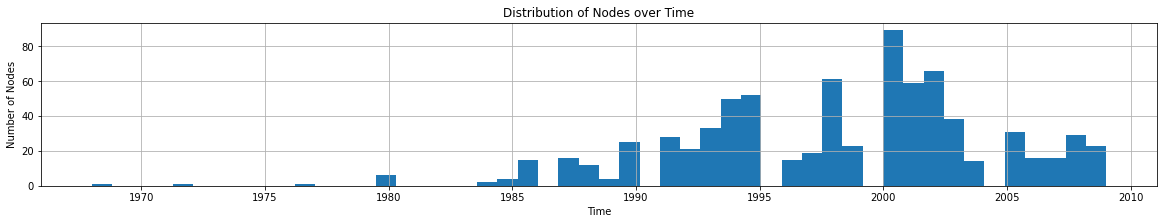

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000224,Proceedings of the Fifth International Confere...,0.000852,VLSI architecture for lossless compression of ...,0.000056,Proceedings of the Fifth International Confere...,1.0,Yoshihisa Gonno
1,0.000198,Proceedings of the 2009 Second International W...,0.000774,Proceedings of the Fifth International Confere...,0.000050,Proceedings of the 2009 Second International W...,1.0,Richard R. Hurtig
2,0.000198,Proceedings of the International Conference on...,0.000722,Wei Li,0.000049,Proceedings of the third international confere...,1.0,Dimitrios Tzimeas
3,0.000198,Proceedings of the IEEE International Conferen...,0.000539,Proceedings of the 7th international conferenc...,0.000049,Proceedings of the International Conference on...,1.0,Josep Riudavets
4,0.000194,Proceedings of the 2009 International Conferen...,0.000524,Wavelet-based image registration technique for...,0.000046,Proceedings of the IEEE International Conferen...,1.0,Claudio DeSanti
5,0.000189,Proceedings of the 2009 International Conferen...,0.000491,Wei Zhang,0.000044,Proceedings of the Eighth ACIS International C...,1.0,Tong Huang
6,0.000187,Proceedings of the 2009 International Conferen...,0.000481,Lei Wang,0.000043,Proceedings of the 2009 International Conferen...,1.0,Zhi-Lin Zhang
7,0.000187,Proceedings of the Eighth ACIS International C...,0.000480,Application of Fuzzy Programming with Recourse...,0.000043,Proceedings of the 2009 International Conferen...,1.0,Joy Jiang
8,0.000177,Proceedings of the 2009 Eigth IEEE/ACIS Intern...,0.000478,Proceedings of the 2009 International Conferen...,0.000041,Proceedings of the 2009 International Forum on...,1.0,Koksoon Phua
9,0.000174,Proceedings of the The Fifth International Con...,0.000436,Proceedings of the 2009 International Conferen...,0.000041,Proceedings of the 2009 International Conferen...,1.0,Merja Karjalainen


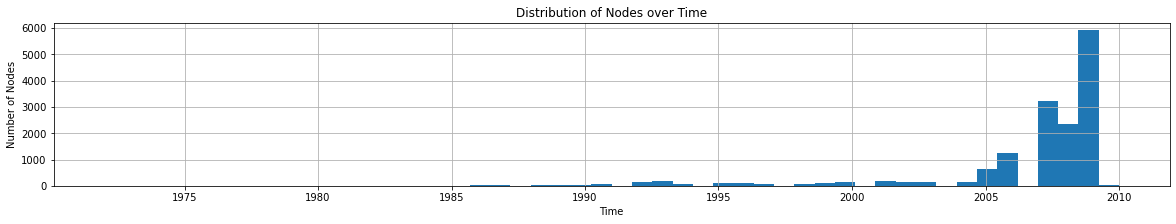

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000142,Proceedings of the 2007 Frontiers in the Conve...,0.000230,Proceedings of the 5th ACIS International Conf...,0.000031,Proceedings of the 2007 Frontiers in the Conve...,0.380952,Scalable interest management using interest gr...
1,0.000122,Proceedings of the 2008 International Conferen...,0.000223,Proceedings of the 2007 Frontiers in the Conve...,0.000029,Proceedings of the 2008 International Conferen...,0.333333,Sami Khawam
2,0.000112,Proceedings of the 5th ACIS International Conf...,0.000176,ACM SIGGRAPH ASIA 2008 computer animation fest...,0.000028,Proceedings of the 5th ACIS International Conf...,0.333333,Ju-Hum Kwon
3,0.000104,Proceedings of the 2006 International Conferen...,0.000168,Proceedings of the 2006 International Conferen...,0.000023,ACM SIGGRAPH ASIA 2008 computer animation fest...,0.333333,Seunghyun Han
4,0.000076,Proceedings of the 8th international conferenc...,0.000162,Proceedings of the 2008 International Conferen...,0.000023,Proceedings of the 2006 International Conferen...,0.333333,Manchul Han
5,0.000071,Proceedings of the The 2007 International Conf...,0.000150,Proceedings of the 8th international conferenc...,0.000020,Proceedings of the 8th international conferenc...,0.300000,Mingyu Lim
6,0.000060,ACM SIGGRAPH ASIA 2008 computer animation fest...,0.000094,Proceedings of the The 2007 International Conf...,0.000016,Proceedings of the The 2007 International Conf...,0.300000,An Efficient Abductive Reasoning System Based ...
7,0.000032,Naohiro Ishii,0.000072,Smith,0.000009,Development of a Neuron Based Internet Game Dr...,0.266667,Interoperability test suite derivation for com...
8,0.000028,Hidenori Itoh,0.000068,Welcome from the General Chairs,0.000007,Activity-Based Computing,0.190476,Process and Location-Aware Information Service...
9,0.000022,Selected proceedings of the IFIP TC6 9th inter...,0.000068,AMTA 2006 International Program Committee,0.000007,A 60-W multicarrier WCDMA power amplifier usin...,0.190476,Context-aware communication support system wit...


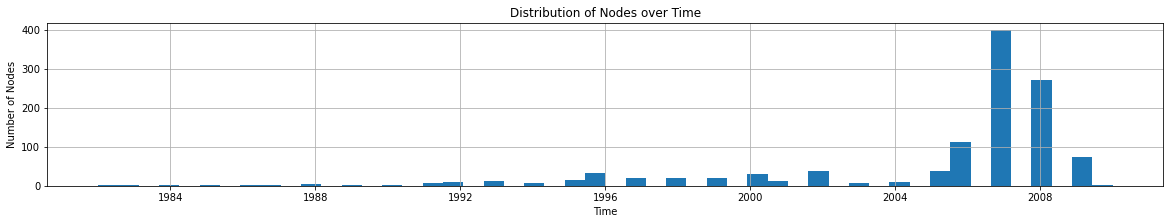

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.002982,IEEE Transactions on Computers,0.008573,IEEE Transactions on Computers,0.000588,IEEE Transactions on Computers,1.0,Karlheinz Agsteiner
1,0.002184,ACM SIGPLAN Notices,0.006238,ACM SIGPLAN Notices,0.000382,ACM SIGPLAN Notices,1.0,J. Altet
2,0.001037,Journal of Parallel and Distributed Computing,0.004104,Xiao Liu,0.000200,Software&mdash;Practice Experience,1.0,Isao Kotera
3,0.000996,IEEE Transactions on Parallel and Distributed ...,0.002838,IEEE Transactions on Parallel and Distributed ...,0.000198,Journal of Parallel and Distributed Computing,1.0,Isamu Yamazaki
4,0.000892,ACM SIGARCH Computer Architecture News,0.002592,Journal of Parallel and Distributed Computing,0.000147,ACM SIGARCH Computer Architecture News,1.0,Petru Eles Traian Pop Zebo Peng
5,0.000872,Software&mdash;Practice Experience,0.002534,"Proceedings of the conference on Design, autom...",0.000133,"Proceedings of the conference on Design, autom...",1.0,Howard David
6,0.000834,"Proceedings of the conference on Design, autom...",0.001938,ACM SIGARCH Computer Architecture News,0.000115,Parallel Computing,1.0,Hiroshi Kadota
7,0.000708,Introduction to algorithms,0.001935,Symbolic analysis for parallelizing compilers,0.000093,IEEE Transactions on Parallel and Distributed ...,1.0,Henan Zhao
8,0.000686,"Compilers: principles, techniques, and tools",0.001850,Automatic translation of FORTRAN programs to v...,0.000086,Journal of Electronic Testing: Theory and Appl...,1.0,G. N. Srinivasa Prasanna
9,0.000566,Parallel Computing,0.001842,A Novel Transition Fault ATPG That Reduces Yie...,0.000080,Proceedings of the conference on European desi...,1.0,José C. García


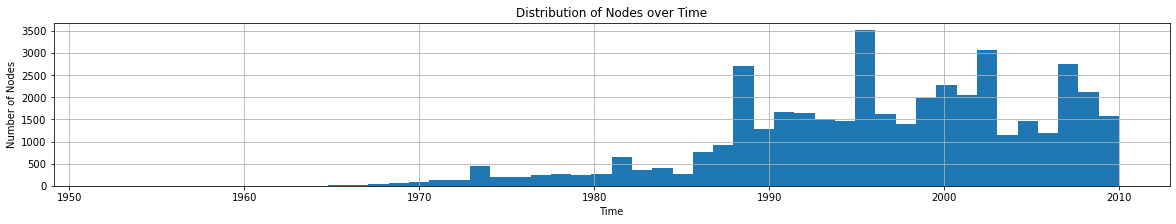

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000473,Journal of Medical Systems,0.001455,Journal of Medical Systems,0.000108,Journal of Medical Systems,1.000000,Data representation and algorithms for biomedi...
1,0.000353,Computers and Biomedical Research,0.000979,Computers and Biomedical Research,0.000083,Computers and Biomedical Research,1.000000,M. Akin
2,0.000043,Behavioral Science,0.000644,Tutorial on Technology Transfer and Survey Des...,0.000019,Synergy between medical informatics and bioinf...,1.000000,Kyoko Takano
3,0.000042,Proc. of the 8th international conference on A...,0.000495,Decision-Making With and Without Information T...,0.000015,Behavioral Science,1.000000,Jalila Jbilou
4,0.000033,Synergy between medical informatics and bioinf...,0.000330,Split-and-merge segmentation of magnetic reson...,0.000013,Proc. of the 8th international conference on A...,1.000000,Nabil Amara
5,0.000030,on Optical information systems '86,0.000073,on Optical information systems '86,0.000012,on Optical information systems '86,1.000000,Michael Fioretos
6,0.000027,Tutorial on Technology Transfer and Survey Des...,0.000066,Behavioral Science,0.000010,Healthcare information management systems,1.000000,Réjean Landry
7,0.000026,Healthcare information management systems,0.000063,Proc. of the 8th international conference on A...,0.000009,William Saffady,0.733333,Information Systems' Approaches and Designs an...
8,0.000022,Aspects of the computer-based patient record,0.000057,Healthcare information management systems,0.000009,Double-blind evaluation and benchmarking of su...,0.666667,Michael D. Rosko
9,0.000020,Guest Editorial: Semantic mashup of biomedical...,0.000054,Blood banking in the AIDS era,0.000008,Percutaneous Transluminal Septal Reduction for...,0.666667,Medical Informatics: A Model Developed for Dia...


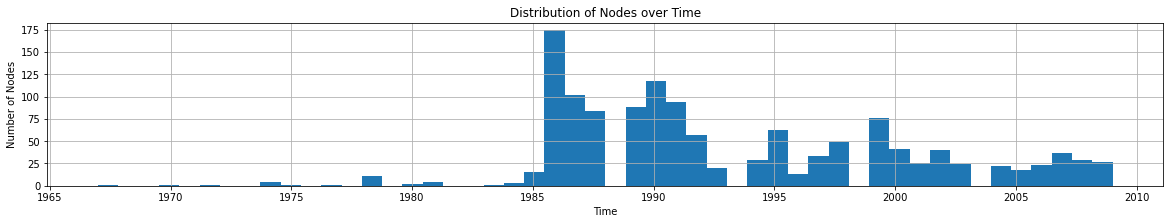

In [34]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

### Label Propagation

In [35]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.6661152694674879
Number of communities: 61189


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

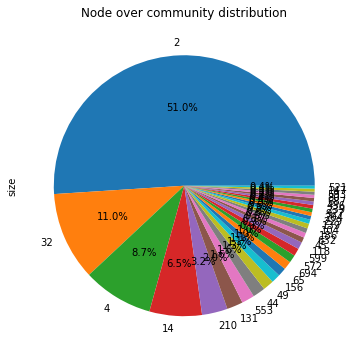

In [36]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,7.775794e-06,Election in a complete network with a sense of...,5.279870e-06,Election in a complete network with a sense of...,4.279116e-06,Election in a complete network with a sense of...,0.0,Michael
1,2.591931e-06,Toward the Use of Automated Static Analysis Al...,9.599763e-08,Michael,5.335975e-07,Toward the Use of Automated Static Analysis Al...,0.0,Toward the Use of Automated Static Analysis Al...
2,1.727954e-06,Michael,0.000000e+00,B. West,4.559876e-07,Michael,0.0,Election in a complete network with a sense of...
3,8.639772e-07,B. West,0.000000e+00,A. Matsushita,2.111942e-07,B. West,NaN,B. West
4,8.639772e-07,A. Matsushita,0.000000e+00,Teresa,2.111942e-07,A. Matsushita,NaN,A. Matsushita
5,8.639772e-07,Teresa,0.000000e+00,C. Loui,2.111942e-07,Teresa,NaN,Teresa
6,8.639772e-07,C. Loui,0.000000e+00,Douglas,2.111942e-07,C. Loui,NaN,C. Loui
7,8.639772e-07,Douglas,0.000000e+00,Toward the Use of Automated Static Analysis Al...,2.111942e-07,Douglas,NaN,Douglas


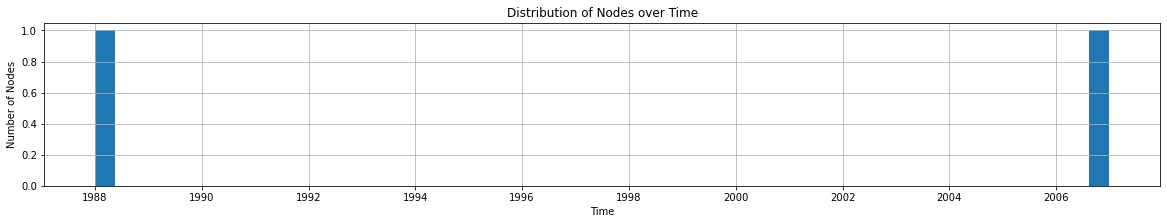

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000051,IEEE,0.000053,IEEE,2.004353e-05,IEEE,0.0,Systems
1,0.000014,Industrial Electronics Society Staff,0.000020,"Atlas Text Language: Standard 416-1984, 2nd ed...",5.698644e-06,Industrial Electronics Society Staff,0.0,Proceedings of the Third IEEE International Sy...
2,0.000012,Communications Society Staff,0.000007,Communications Society Staff,4.719471e-06,Communications Society Staff,0.0,"1995 IEEE Conference on Communications, Power ..."
3,0.000003,Neural Networks Council Staff,0.000007,Industrial Electronics Society Staff,1.663259e-06,Proceedings of the Third IEEE International Sy...,0.0,"IEEE International Conference on Systems, Man ..."
4,0.000003,Proceedings of the Third IEEE International Sy...,0.000003,1996 IEEE Conference on Emerging Technologies ...,1.656702e-06,IECON '98: Proceedings of the 24th Annual Conf...,0.0,IEEE Symposium on Emerging Technologies and Fa...
5,0.000003,IECON '98: Proceedings of the 24th Annual Conf...,0.000003,1996 IECON 22nd International Conference on In...,1.610803e-06,"Non-Volatile Memory Technology Review Meeting,...",0.0,IEEE - Tsukuba International Workshop on Advan...
6,0.000003,"IEEE International Conference on Systems, Man ...",0.000002,"Pattern Recognition (Icpr '98), 1998 Internati...",1.598356e-06,Neural Networks Council Staff,0.0,7th IEEE Intelligent Network Workshop: Proceed...
7,0.000003,"1995 IEEE International Conference on Systems,...",0.000002,"Third International Symposium on Personal, Ind...",9.288792e-07,7th IEEE Intelligent Network Workshop: Proceed...,0.0,1998 IEEE Fifth International Symposium on Spr...
8,0.000003,1998 IEEE/Rsj International Conference on Inte...,0.000002,1998 IEEE Fifth International Symposium on Spr...,9.288792e-07,Proceedings: 1998 IEEE 4th Workshop on Interac...,0.0,1996 IEEE Conference on Emerging Technologies ...
9,0.000003,7th IEEE Intelligent Network Workshop: Proceed...,0.000002,"Non-Volatile Memory Technology Review Meeting,...",9.223223e-07,1998 IEEE/Rsj International Conference on Inte...,0.0,"Pattern Recognition (Icpr '98), 1998 Internati..."


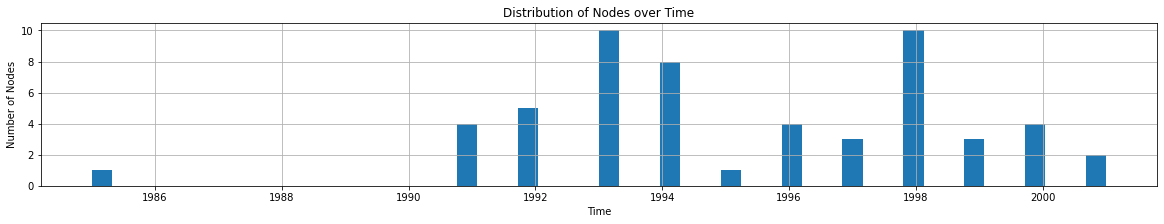

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.002826,Theoretical Computer Science,0.236308,"The art of computer programming, volume 1 (3rd...",0.000660,Theoretical Computer Science,1.0,Peter Gloor
1,0.002324,Information Processing Letters,0.102337,Foundations of logic programming; (2nd extende...,0.000597,Information Processing Letters,1.0,Database step-by-step (2nd ed.)
2,0.001748,Discrete Applied Mathematics,0.039632,A survey on wavelet applications in data mining,0.000419,Discrete Applied Mathematics,1.0,Mikko Kerttula
3,0.001068,Information Sciences: an International Journal,0.034451,A novel method for parameter optimization in t...,0.000243,Information Sciences: an International Journal,1.0,Collin Baker
4,0.001047,IEEE Transactions on Knowledge and Data Engine...,0.032756,Depth-first digraph algorithms without recursion,0.000198,Journal of Parallel and Distributed Computing,1.0,Susan M. Hubbard
5,0.001037,Journal of Parallel and Distributed Computing,0.032275,An introduction to inductive logic programming,0.000194,SIAM Journal on Computing,1.0,On broadcast switching networks
6,0.000996,IEEE Transactions on Parallel and Distributed ...,0.025663,Swarm intelligence,0.000182,ACM SIGACT News,1.0,J. K. Watson
7,0.000983,SIAM Journal on Computing,0.024506,Some new properties for capacitated lot-sizing...,0.000166,Information and Computation,1.0,J. Blumer
8,0.000839,ACM SIGMOD Record,0.014238,Direct search methods: then and now,0.000158,Information Processing and Management: an Inte...,1.0,D. A. Schlobohm
9,0.000829,Information and Computation,0.013697,"Real and complex analysis, 3rd ed.",0.000146,SIAM Journal on Discrete Mathematics,1.0,Guy Pardon


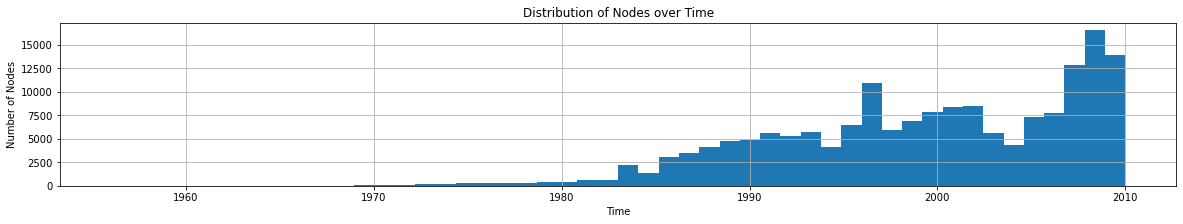

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000008,Zhiyong Li,3.303345e-06,Synthesizing Efficient Out-of-Core Programs fo...,2.161381e-06,Zhiyong Li,0.0,H
1,0.000005,Xiaoying Li,1.818902e-06,Simulated Annealing Parallel Genetic Algorithm...,1.343392e-06,Synthesizing Efficient Out-of-Core Programs fo...,0.0,Zhiyong Li
2,0.000004,Modulation Strategy Research for Dual Bridge M...,1.367966e-06,Voltage Transfer Characteristic Analysis of Ma...,1.255646e-06,Xiaoying Li,0.0,Xiaoying Li
3,0.000004,Synthesizing Efficient Out-of-Core Programs fo...,1.079973e-06,A Novel Over Modulation Strategy for Two-Stage...,1.234551e-06,Voltage Transfer Characteristic Analysis of Ma...,0.0,Hao Cai
4,0.000003,Voltage Transfer Characteristic Analysis of Ma...,1.045869e-06,Zhiyong Li,9.496541e-07,Simulated Annealing Parallel Genetic Algorithm...,0.0,Xiangdong Kong
5,0.000003,A Novel Over Modulation Strategy for Two-Stage...,6.204634e-07,H,9.489275e-07,Modulation Strategy Research for Dual Bridge M...,0.0,Simulated Annealing Parallel Genetic Algorithm...
6,0.000003,Hao Cai,0.000000e+00,Xilu Zhu,7.041651e-07,A Novel Over Modulation Strategy for Two-Stage...,0.0,Voltage Transfer Characteristic Analysis of Ma...
7,0.000003,Simulated Annealing Parallel Genetic Algorithm...,0.000000e+00,Xiaoying Li,6.069434e-07,Hao Cai,0.0,Modulation Strategy Research for Dual Bridge M...
8,0.000002,H,0.000000e+00,Yue Cai,4.600674e-07,Xiangdong Kong,0.0,Synthesizing Efficient Out-of-Core Programs fo...
9,0.000002,Xiangdong Kong,0.000000e+00,Hao Cai,3.813839e-07,H,0.0,A Novel Over Modulation Strategy for Two-Stage...


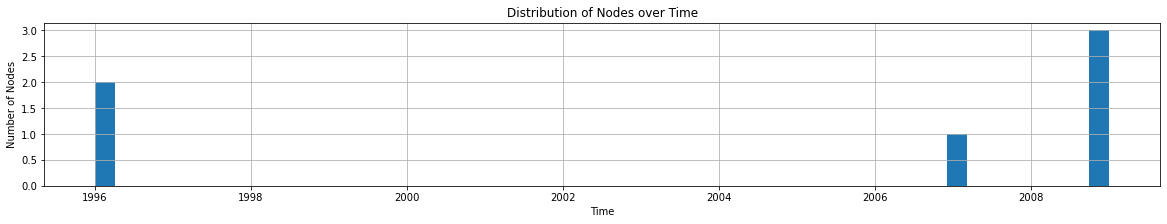

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.001007,IEEE Design Test,0.015187,BI-CGSTAB: a fast and smoothly converging vari...,0.000281,IEEE Design Test,1.0,Joseph T. Buck
1,0.000892,ACM SIGARCH Computer Architecture News,0.004104,Xiao Liu,0.000147,ACM SIGARCH Computer Architecture News,1.0,Costin Iancu
2,0.000834,"Proceedings of the conference on Design, autom...",0.002536,A Single-Chip Multiprocessor for Smart Terminals,0.000133,"Proceedings of the conference on Design, autom...",1.0,Nitya Ranganathan
3,0.000686,"Compilers: principles, techniques, and tools",0.002534,"Proceedings of the conference on Design, autom...",0.000086,Journal of Electronic Testing: Theory and Appl...,1.0,Michael S. Warren
4,0.000489,IEEE Transactions on Very Large Scale Integrat...,0.001938,ACM SIGARCH Computer Architecture News,0.000080,Proceedings of the conference on European desi...,1.0,Filip Van Aelten
5,0.000472,Proceedings of the conference on European desi...,0.001935,Symbolic analysis for parallelizing compilers,0.000071,"Integration, the VLSI Journal",1.0,L. Svensson
6,0.000457,Journal of Electronic Testing: Theory and Appl...,0.001850,Automatic translation of FORTRAN programs to v...,0.000070,Journal of VLSI Signal Processing Systems,1.0,Milind Kulkarni
7,0.000411,Journal of VLSI Signal Processing Systems,0.001842,A Novel Transition Fault ATPG That Reduces Yie...,0.000068,IEEE Transactions on Very Large Scale Integrat...,1.0,Andy Yan
8,0.000398,Graph-Based Algorithms for Boolean Function Ma...,0.001785,IEEE Design Test,0.000058,Journal of Systems Architecture: the EUROMICRO...,1.0,A. Vandecappelle
9,0.000320,"Integration, the VLSI Journal",0.001703,On the Complexity of VLSI Implementations and ...,0.000049,International Journal of Parallel Programming,1.0,W.-M. W. Hwu


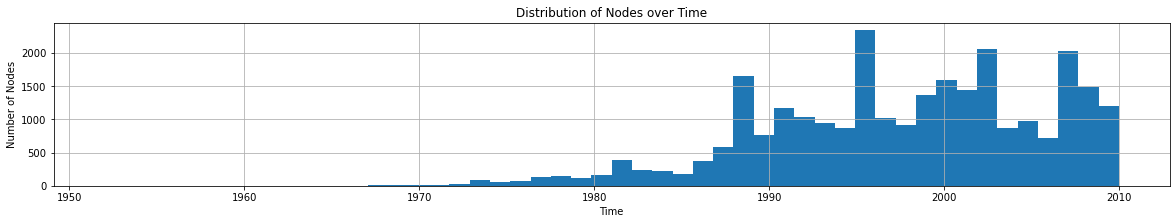

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,3.455909e-06,Comparison of 2-d gel electrophoresis images,0.000003,Comparison of 2-d gel electrophoresis images,1.965998e-06,Comparison of 2-d gel electrophoresis images,0.0,Comparison of 2-d gel electrophoresis images
1,8.639772e-07,H.-S. Ip,0.000000,H.-S. Ip,3.131915e-07,H.-S. Ip,NaN,H.-S. Ip
2,8.639772e-07,Horace,0.000000,Horace,3.131915e-07,Horace,NaN,Horace


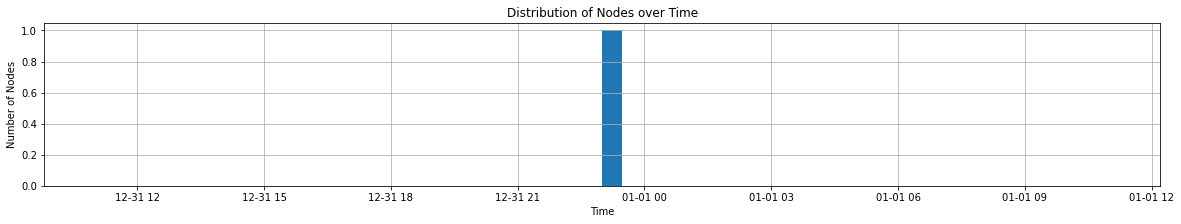

In [37]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')